In [4]:
import matplotlib.pyplot as plt
import pickle
import os
from od.social import SocialGroup
from od.network.types import ResourceAllocatorType,BaseStationType
from od.misc.interest import InterestConfig
from numpy import random
plt.rcParams.update(
    {
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "legend.loc":"upper left",
    "legend.framealpha":0.3,
    "font.size":14,
    }
)

In [5]:
def GetLineMarkerStyle(line_no):
    line_style = ['--','-.',':']
    marker_style = ['o','v','^','<','>','s','p','*','h','H','x','D']
    line_no = line_no % (len(line_style)*len(marker_style))
    return marker_style[int(line_no%len(marker_style))] + line_style[int(line_no/(len(marker_style)))]
#     return marker_style[int(line_no/len(line_style))] + line_style[int(line_no%(len(line_style)))]

In [6]:
sg_graph_configs = [
    {
        "catalog": "veh_recv_intact_appdata_trip",
        "topic": "End-to-End Time",
#         "x": "Maximum Data Generated Per Second(Unique Distribution) ",
        "x": "Traffic Scale",
        "y": "Time(Second)",
        "subject": ["Avg", "Max", "Min"]
    },
    {
        "catalog": "bs_appdata_txq_wait",
        "topic": "Wait Time in Downlink Queue",
        "x": "Traffic Scale",
        "y": "Time(Second)",
        "subject": ["Avg", "Max", "Min"]
    },
    {
        "catalog": "bs_appdata_tx",
        "topic": "Transfer Time",
        "x": "Traffic Scale",
        "y": "Time(Second)",
        "subject": ["Avg", "Max", "Min"]
    },
]


In [7]:
nsg_graph_configs = [
    {
        "catalog": "bs_through_put",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
    
]


In [8]:
bs_sg_graph_configs = [
    {
        "catalog": "bs_sg_res_use_rate",
        "topic": "Social-Group Traffic Service Ratio",
        "x": "Traffic Scale",
        "y": "%",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]



In [9]:
sys_graph_configs = [
    {
        "catalog": "sys_through_put",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
    },
]

In [10]:
bs_names = {
    BaseStationType.UMA: "4G-eNB",
    BaseStationType.UMI: "5G-gNB",
}

In [11]:
def ExtractAbbreviations(abbrev):
    if(abbrev == "Avg"):
        return "Average"
    elif(abbrev == "Max"):
        return "Maximum"
    elif(abbrev == "Min"):
        return "Minimum"

In [12]:
def BaseStationScenario(with_rsu):
    if(with_rsu):
        return "4G+5G"
    else:
        return  "4G"

In [37]:
s = [13232421, 102948123, 4419883, 5157253]
# s = [13232421]
a = [t for t in ResourceAllocatorType]
b = [False, True]
c = [0.2, 0.25, 0.3, 0.35, 0.4,0.45, 0.5, 0.55, 0.6, 0.65]

In [38]:
interest_config = InterestConfig(None, False, 0)
stats = [[[[None for _c in c] for _b in b] for _a in a]for _s in s]
for _s , seed in enumerate(s):
    for _a, res_alloc_type in enumerate(a):
        for _b, req_rsu in enumerate(b):
            for _c, traffic_scale in enumerate(c):
                interest_config.res_alloc_type = res_alloc_type
                interest_config.req_rsu = req_rsu
                interest_config.traffic_scale = traffic_scale
                with open("data/{}/{}/report.pickle".format(seed,str(interest_config)), "rb") as file:
                    stats[_s][_a][_b][_c] = pickle.load(file)

In [39]:
# create picture folder
dirpath = "pics/"
if not os.path.isdir(dirpath):
    os.mkdir(dirpath)

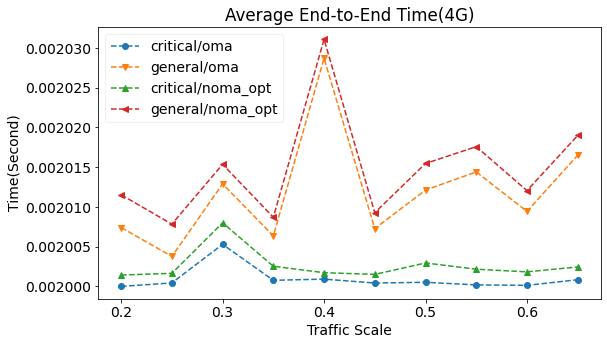

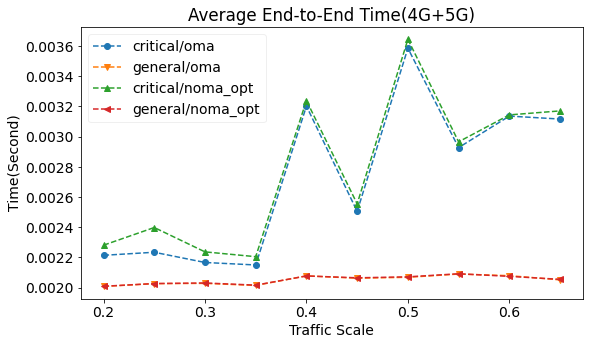

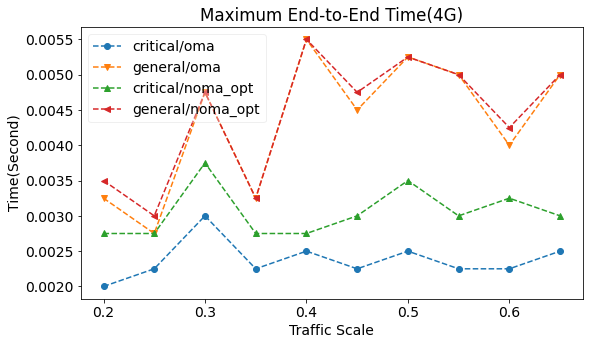

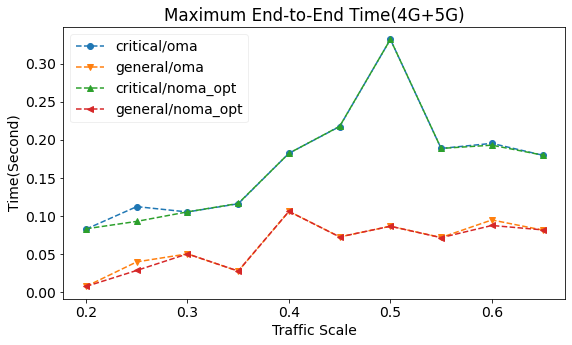

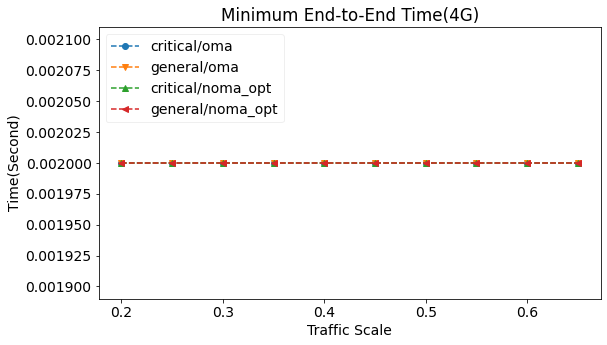

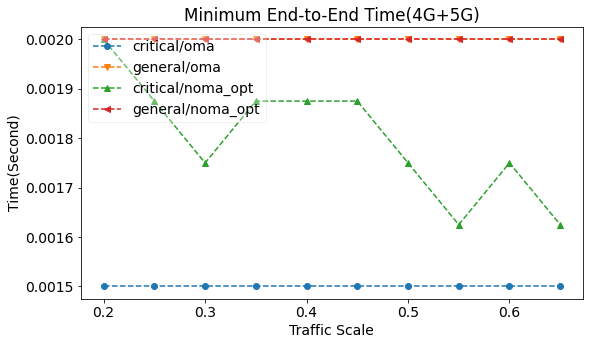

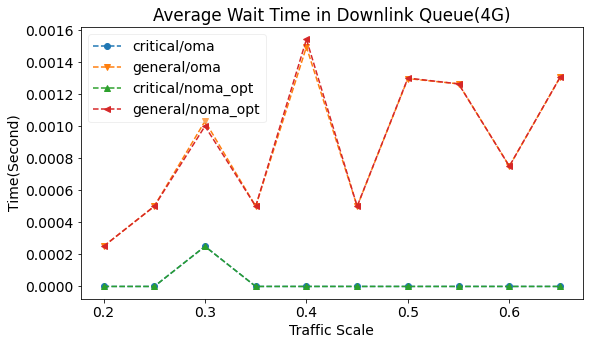

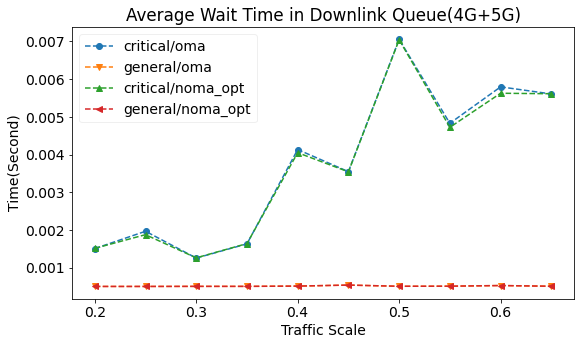

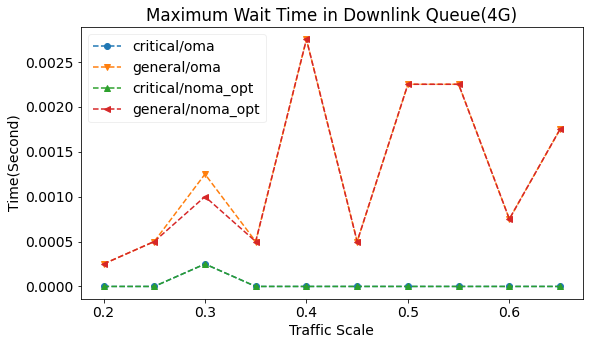

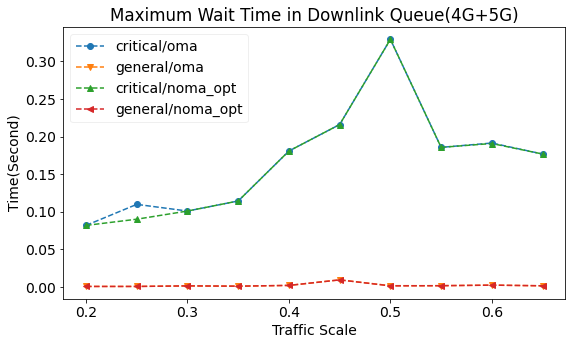

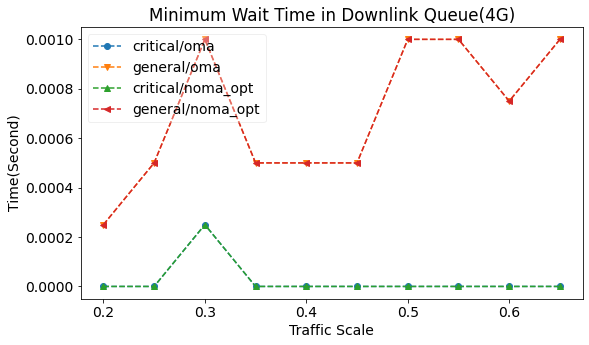

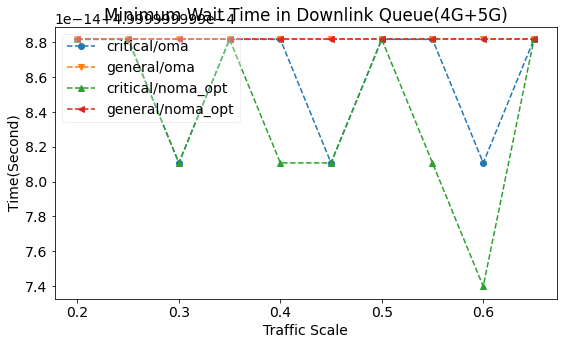

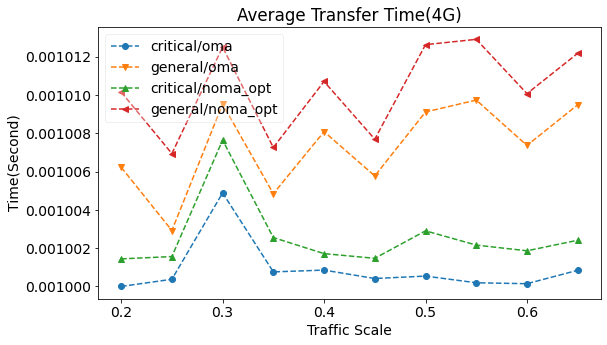

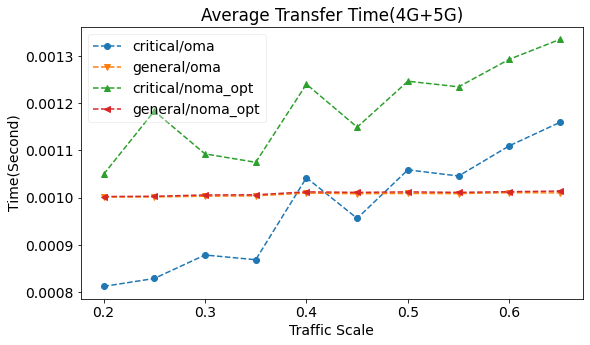

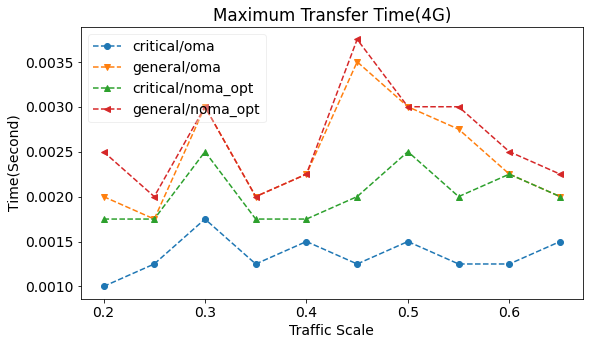

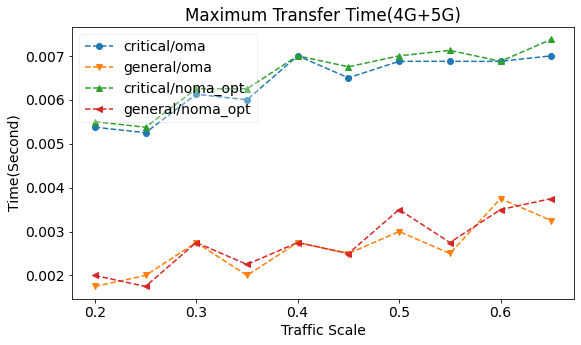

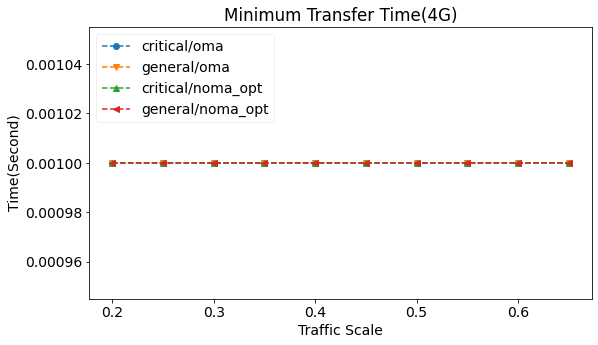

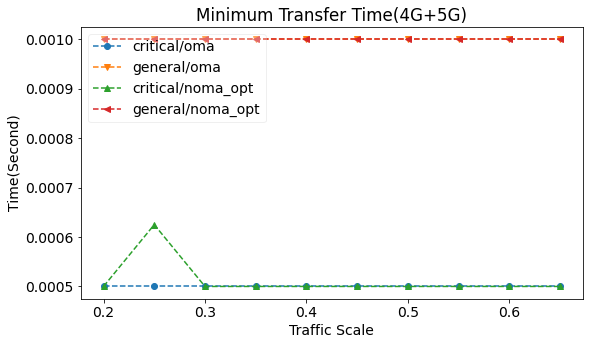

In [40]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in sg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for _b in range(len(b)):
            title = "{} {}({})".format(
                ExtractAbbreviations(subject), 
                topic,
                BaseStationScenario(b[_b])
            )
            plt.figure(serial, figsize=(9, 5))
            plt.xlabel(config["x"])
            plt.ylabel(config["y"])
            plt.title(title)
            line_no = 0
            for _a in range(len(a)):
                for sg in SocialGroup:
                    y = []
                    x = c
                    for _c in range(len(c)):
                        value = 0
                        for _s in range(len(s)):
                            v = stats[_s][_a][_b][_c][catalog][sg][subject.lower()]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value += v
                        y.append(value/len(s))
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}/{}".format(
                              str(sg).lower(),
                              a[_a].name.lower(),
                        )
                    )
                    line_no += 1
                    #   plt.text(
                    #     c[-1],
                    #     y[-1],
                    #   )
            plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
            plt.savefig('{}/{}.pdf'.format(dirpath, title))
            serial += 1
plt.show()


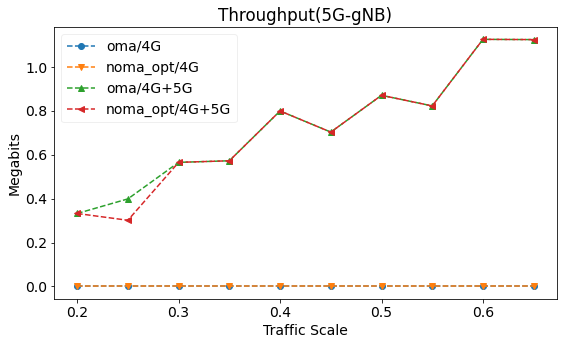

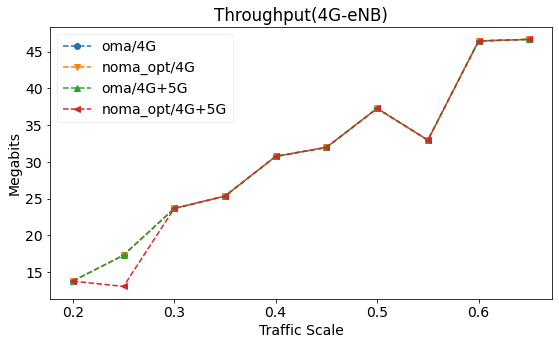

In [41]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in nsg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        title = "{}({})".format(
            topic, 
            bs_names[subject]
        )
        plt.figure(serial, figsize=(9, 5))
        plt.xlabel(config["x"])
        plt.ylabel(config["y"])
        plt.title(title)
        line_no = 0
        for _b in range(len(b)):
            for _a in range(len(a)):
                y = []
                x = c
                for _c in range(len(c)):
                    value = 0
                    for _s in range(len(s)):
                        v = stats[_s][_a][_b][_c][catalog][subject]
                        if v == _pinf or v == _ninf:
                            v = 0
                        value += v
                    y.append((value/len(s))/10**6)
                plt.plot(
                    x,
                    y,
                    GetLineMarkerStyle(line_no),
                    label="{}/{}".format(
                        a[_a].name.lower(),
                        BaseStationScenario(b[_b])
                    )
                )
                line_no += 1
                #   plt.text(
                #     c[-1],
                #     y[-1],
                #   )
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
        plt.savefig('{}/{}.pdf'.format(dirpath, title))
        serial += 1
plt.show()


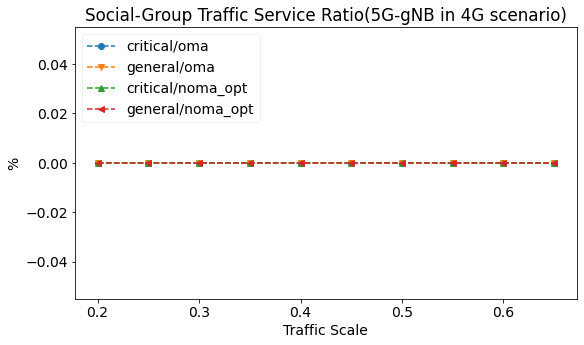

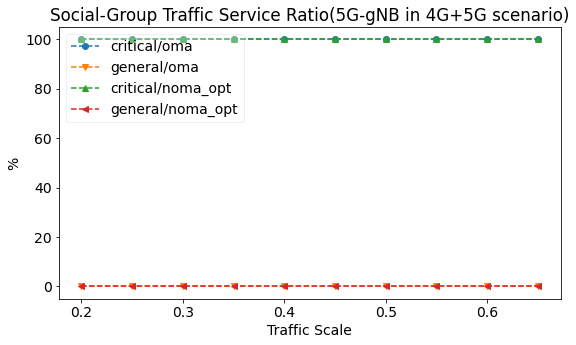

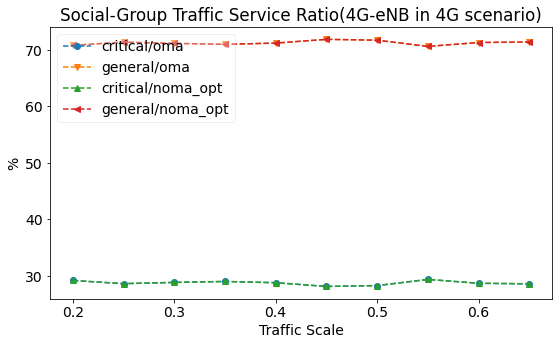

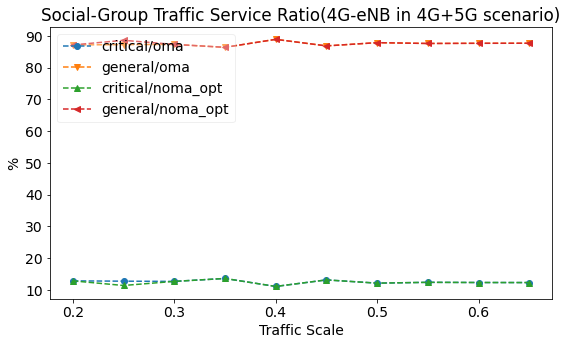

In [42]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1

for config in bs_sg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for _b in range(len(b)):
            title = "{}({} in {} scenario)".format(
                    topic,
                    bs_names[subject],
                    BaseStationScenario(b[_b])
            )
            plt.figure(serial, figsize=(9, 5))
            plt.xlabel(config["x"])
            plt.ylabel(config["y"])
            plt.title(title)
            line_no = 0
            for _a in range(len(a)):
           
                for sg in SocialGroup:
                    y = []
                    x = c
                    for _c in range(len(c)):
                        value = 0
                        for _s in range(len(s)):
                            v = stats[_s][_a][_b][_c][catalog][subject][sg]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value += v
                        y.append(value/len(s) * 100)
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}/{}".format(
                              str(sg).lower(),
                              a[_a].name.lower(),
                        )
                    )
                    line_no += 1
                    #   plt.text(
                    #     c[-1],
                    #     y[-1],
                    #   )
#         plt.ylim([-10,110])
            plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
            plt.savefig('{}/{}.pdf'.format(dirpath, title))
            serial += 1
plt.show()


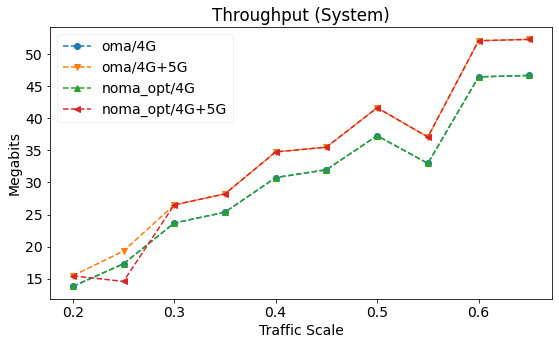

In [43]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1

for config in sys_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    title = "{} (System)".format(topic)
    plt.figure(serial, figsize=(9, 5))
    plt.xlabel(config["x"])
    plt.ylabel(config["y"])
    plt.title(title)
    line_no = 0
    for _a in range(len(a)):
        for _b in range(len(b)):
            y = []
            x = c
            for _c in range(len(c)):
                value = 0
                for _s in range(len(s)):
                    v = stats[_s][_a][_b][_c][catalog]
                    if v == _pinf or v == _ninf:
                        v = 0
                    value += v
                y.append(value/len(s)/10**6)
            plt.plot(
                x,
                y,
                GetLineMarkerStyle(line_no),
                label="{}/{}".format(
                    a[_a].name.lower(),
                    BaseStationScenario(b[_b])
                )
            )
            line_no += 1
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.savefig('{}/{}.pdf'.format(dirpath, title))
    serial += 1
plt.show()
